In [9]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


##### ===== 1. GERAÇÃO DE DADOS ARTIFICIAIS =====

In [10]:
def gerar_sequencia_dna(tamanho=10, gc_content=0.5):
    """Gera sequência artificial de DNA"""
    bases = ['A', 'C', 'G', 'T']
    # Ajusta probabilidades para simular GC content
    p_gc = gc_content / 2
    p_at = (1 - gc_content) / 2
    probs = [p_at, p_gc, p_gc, p_at]
    
    return ''.join(np.random.choice(bases, size=tamanho, p=probs))

In [11]:
def gerar_fragmentos_cfdna(n_fragmentos=1000, tamanho=10, gc_content=0.5):
    """Gera conjunto de fragmentos de cfDNA artificiais"""
    return [gerar_sequencia_dna(tamanho, gc_content) for _ in range(n_fragmentos)]

##### ===== 2. CÁLCULO DO FOTP (First-Order Transition Probability) =====

In [12]:
def calcular_probabilidade_inicial(sequencias):
    """Calcula P1^i - frequência inicial dos 4 nucleotídeos"""
    contagem = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    total = 0
    
    for seq in sequencias:
        if len(seq) > 0:
            contagem[seq[0]] += 1
            total += 1
    
    prob_inicial = {base: contagem[base]/total for base in contagem}
    return prob_inicial

In [13]:
def calcular_fotp(sequencias):
    """
    Calcula FOTP - Probabilidades de transição de primeira ordem
    Retorna matriz 16x(N-1) onde N é o tamanho da sequência
    """
    if not sequencias:
        return None
    
    tamanho_seq = len(sequencias[0])
    bases = ['A', 'C', 'G', 'T']
    dinucleotideos = [b1+b2 for b1 in bases for b2 in bases]
    
    # Inicializa contadores para cada posição
    transicoes = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    
    # Conta transições em cada posição
    for seq in sequencias:
        for pos in range(len(seq) - 1):
            base_atual = seq[pos]
            base_proxima = seq[pos + 1]
            dinuc = base_atual + base_proxima
            transicoes[pos][base_atual][dinuc] += 1
    
    # Calcula probabilidades
    fotp_matrix = np.zeros((len(dinucleotideos), tamanho_seq - 1))
    
    for pos in range(tamanho_seq - 1):
        for i, dinuc in enumerate(dinucleotideos):
            base_atual = dinuc[0]
            total_base = sum(transicoes[pos][base_atual].values())
            if total_base > 0:
                fotp_matrix[i, pos] = transicoes[pos][base_atual][dinuc] / total_base
    
    return fotp_matrix, dinucleotideos

##### ===== 3. CÁLCULO DO SOTP (Second-Order Transition Probability) =====

In [14]:
def calcular_sotp(sequencias):
    """Calcula SOTP - Probabilidades de transição de segunda ordem"""
    if not sequencias:
        return None
    
    tamanho_seq = len(sequencias[0])
    bases = ['A', 'C', 'G', 'T']
    trinucleotideos = [b1+b2+b3 for b1 in bases for b2 in bases for b3 in bases]
    
    # Inicializa contadores
    transicoes = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    
    # Conta transições
    for seq in sequencias:
        for pos in range(len(seq) - 2):
            dinuc_atual = seq[pos:pos+2]
            trinuc = seq[pos:pos+3]
            transicoes[pos][dinuc_atual][trinuc] += 1
    
    # Calcula probabilidades
    sotp_matrix = np.zeros((len(trinucleotideos), tamanho_seq - 2))
    
    for pos in range(tamanho_seq - 2):
        for i, trinuc in enumerate(trinucleotideos):
            dinuc_atual = trinuc[:2]
            total_dinuc = sum(transicoes[pos][dinuc_atual].values())
            if total_dinuc > 0:
                sotp_matrix[i, pos] = transicoes[pos][dinuc_atual][trinuc] / total_dinuc
    
    return sotp_matrix, trinucleotideos

##### ===== 4. EXTRAÇÃO DE FEATURES =====

In [15]:
def extrair_features_fotp(sequencias):
    """Extrai vetor de features FOTP para uma amostra"""
    prob_inicial = calcular_probabilidade_inicial(sequencias)
    fotp_matrix, dinucs = calcular_fotp(sequencias)
    
    # Concatena probabilidade inicial + todas as transições
    features = list(prob_inicial.values())
    features.extend(fotp_matrix.flatten())
    
    return np.array(features)

##### ===== 5. EXEMPLO DE USO =====

In [17]:
# Simula duas populações: saudável vs câncer
# (cancer tem maior GC content no início - simplificação)
print("\n1. Gerando fragmentos artificiais...")
fragmentos_saudavel = gerar_fragmentos_cfdna(n_fragmentos=500, tamanho=10, gc_content=0.45)
fragmentos_cancer = gerar_fragmentos_cfdna(n_fragmentos=500, tamanho=10, gc_content=0.60)

print(f"   Saudável: {len(fragmentos_saudavel)} fragmentos")
print(f"   Câncer: {len(fragmentos_cancer)} fragmentos")
print(f"   Exemplo de fragmento: {fragmentos_saudavel[0]}")


1. Gerando fragmentos artificiais...
   Saudável: 500 fragmentos
   Câncer: 500 fragmentos
   Exemplo de fragmento: GGGAATATTA


In [18]:
# Calcula probabilidades iniciais
print("\n2. Probabilidades iniciais (P1^i):")
prob_ini_saudavel = calcular_probabilidade_inicial(fragmentos_saudavel)
prob_ini_cancer = calcular_probabilidade_inicial(fragmentos_cancer)

df_prob_ini = pd.DataFrame({
    'Base': ['A', 'C', 'G', 'T'],
    'Saudável': [prob_ini_saudavel[b] for b in ['A', 'C', 'G', 'T']],
    'Câncer': [prob_ini_cancer[b] for b in ['A', 'C', 'G', 'T']]
})
print(df_prob_ini.to_string(index=False))


2. Probabilidades iniciais (P1^i):
Base  Saudável  Câncer
   A     0.290   0.190
   C     0.246   0.252
   G     0.228   0.342
   T     0.236   0.216


In [19]:
# Calcula FOTP
print("\n3. Calculando FOTP...")
fotp_saudavel, dinucs = calcular_fotp(fragmentos_saudavel)
fotp_cancer, _ = calcular_fotp(fragmentos_cancer)

print(f"   Dimensões FOTP: {fotp_saudavel.shape}")
print(f"   (16 dinucleotídeos × {fotp_saudavel.shape[1]} transições)")


3. Calculando FOTP...
   Dimensões FOTP: (16, 9)
   (16 dinucleotídeos × 9 transições)


In [20]:
# Mostra algumas transições
print("\n4. Exemplo de transições na posição 1→2:")
exemplos_dinuc = ['CC', 'GC', 'TC', 'AA']
for dinuc in exemplos_dinuc:
    idx = dinucs.index(dinuc)
    print(f"   {dinuc}: Saudável={fotp_saudavel[idx, 0]:.3f}, "
          f"Câncer={fotp_cancer[idx, 0]:.3f}")


4. Exemplo de transições na posição 1→2:
   CC: Saudável=0.244, Câncer=0.286
   GC: Saudável=0.254, Câncer=0.310
   TC: Saudável=0.237, Câncer=0.306
   AA: Saudável=0.283, Câncer=0.137


In [21]:
# Extrai vetor de features completo
print("\n5. Vetor de features FOTP:")
features_saudavel = extrair_features_fotp(fragmentos_saudavel)
features_cancer = extrair_features_fotp(fragmentos_cancer)
print(f"   Dimensão do vetor: {len(features_saudavel)}")
print(f"   Fórmula: 4 (prob. inicial) + 16 × (N-1) transições")
print(f"   = 4 + 16 × 9 = 148 features")


5. Vetor de features FOTP:
   Dimensão do vetor: 148
   Fórmula: 4 (prob. inicial) + 16 × (N-1) transições
   = 4 + 16 × 9 = 148 features


In [22]:
print("\n6. Calculando SOTP...")
sotp_saudavel, trinucs = calcular_sotp(fragmentos_saudavel)
print(f"   Dimensões SOTP: {sotp_saudavel.shape}")
print(f"   (64 trinucleotídeos × {sotp_saudavel.shape[1]} transições)")


6. Calculando SOTP...
   Dimensões SOTP: (64, 8)
   (64 trinucleotídeos × 8 transições)


##### ===== 6. VISUALIZAÇÕES =====


7. Gerando visualizações...


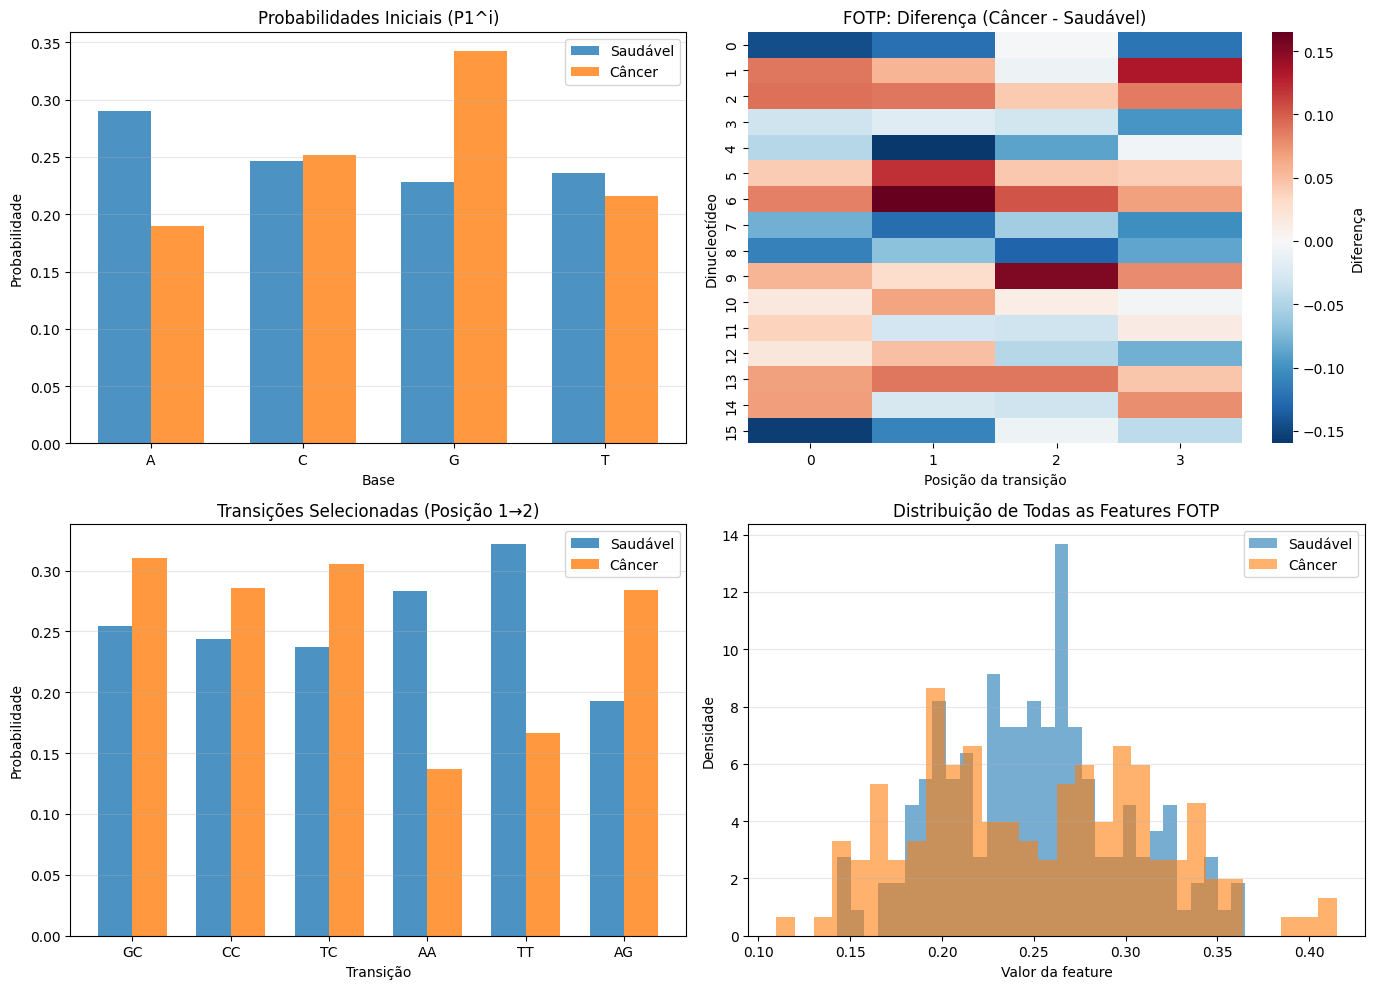


Análise concluída!

NOTA: Este é um exemplo simplificado com dados artificiais.
No artigo real, os dados vêm de sequenciamento de cfDNA real,
e o modelo SVM é treinado com PCA e validação cruzada.


In [23]:
print("\n7. Gerando visualizações...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Probabilidades iniciais
ax = axes[0, 0]
x = np.arange(4)
width = 0.35
ax.bar(x - width/2, df_prob_ini['Saudável'], width, label='Saudável', alpha=0.8)
ax.bar(x + width/2, df_prob_ini['Câncer'], width, label='Câncer', alpha=0.8)
ax.set_xlabel('Base')
ax.set_ylabel('Probabilidade')
ax.set_title('Probabilidades Iniciais (P1^i)')
ax.set_xticks(x)
ax.set_xticklabels(['A', 'C', 'G', 'T'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Heatmap FOTP (primeiras 4 posições)
ax = axes[0, 1]
sns.heatmap(fotp_cancer[:, :4] - fotp_saudavel[:, :4], 
            cmap='RdBu_r', center=0, ax=ax, cbar_kws={'label': 'Diferença'})
ax.set_title('FOTP: Diferença (Câncer - Saudável)')
ax.set_ylabel('Dinucleotídeo')
ax.set_xlabel('Posição da transição')

# Plot 3: Comparação de algumas transições específicas
ax = axes[1, 0]
transicoes_interesse = ['GC', 'CC', 'TC', 'AA', 'TT', 'AG']
pos = 0  # primeira transição (1→2)
valores_saudavel = [fotp_saudavel[dinucs.index(d), pos] for d in transicoes_interesse]
valores_cancer = [fotp_cancer[dinucs.index(d), pos] for d in transicoes_interesse]

x = np.arange(len(transicoes_interesse))
ax.bar(x - width/2, valores_saudavel, width, label='Saudável', alpha=0.8)
ax.bar(x + width/2, valores_cancer, width, label='Câncer', alpha=0.8)
ax.set_xlabel('Transição')
ax.set_ylabel('Probabilidade')
ax.set_title('Transições Selecionadas (Posição 1→2)')
ax.set_xticks(x)
ax.set_xticklabels(transicoes_interesse)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Distribuição de features
ax = axes[1, 1]
ax.hist(features_saudavel, bins=30, alpha=0.6, label='Saudável', density=True)
ax.hist(features_cancer, bins=30, alpha=0.6, label='Câncer', density=True)
ax.set_xlabel('Valor da feature')
ax.set_ylabel('Densidade')
ax.set_title('Distribuição de Todas as Features FOTP')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Análise concluída!")
print("="*60)
print("\nNOTA: Este é um exemplo simplificado com dados artificiais.")
print("No artigo real, os dados vêm de sequenciamento de cfDNA real,")
print("e o modelo SVM é treinado com PCA e validação cruzada.")